## Data requisition

run `data/gene_expression_example/create_dataset.R` with accession codes: GSE26639, GSE76275 in order to download gene expression data matrices.

In [1]:
import os
import sys

if "notebooks" in os.getcwd():
    main_dir = os.getcwd()[:-10]
    os.chdir("../scripts/GPA_NN")
elif "/scripts/GPA_NN" in os.getcwd():
    main_dir = os.getcwd()[:-15]
sys.path.append(main_dir)


import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

import pandas as pd
import pickle as pk

from geomloss import SamplesLoss
import torch
def sinkhorn(X, Y):
    X = torch.from_numpy(X).type(torch.float32)
    Y = torch.from_numpy(Y).type(torch.float32)

    return SamplesLoss(loss='sinkhorn', p=2)(X, Y).numpy()

import matplotlib.pyplot as plt
import umap

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

d_red = 50

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versi

## Dimension reduction using PCA

In [2]:
folder_name = main_dir + "/data/gene_expression_example/GPL570/Labeled_disease/"
source_name = "GSE26639"
target_name = "GSE76275"
dset1_name = folder_name + source_name +".csv" # source distribution
dset2_name = folder_name + target_name +".csv" # target distribution

# read datasets
data1 = pd.read_csv(dset1_name)
X1 = pd.DataFrame.to_numpy(data1).T
(n1, d) = X1.shape
print("source data dimensions: ", n1, d)

data2 = pd.read_csv(dset2_name)
X2 = pd.DataFrame.to_numpy(data2).T
n2 = X2.shape[0]
print("target data dimensions: ", n2, d)

# read data labels
dset1_label_name = folder_name + source_name + "_label.csv" # source distribution label
dset2_label_name = folder_name + target_name + "_label.csv" # target distribution label

label1 = pd.read_csv(dset1_label_name, header=None)
X1_label = np.zeros(len(label1))
l1 = np.squeeze(pd.DataFrame.to_numpy(label1))
X1_label[l1 == 'positive'] = 1
X1_label[l1 == 'Positive'] = 1

label2 = pd.read_csv(dset2_label_name, header=None)
X2_label = np.zeros(len(label2))
l2 = np.squeeze(pd.DataFrame.to_numpy(label2))
X2_label[l2 == 'positive'] = 1
X2_label[l2 == 'Positive'] = 1

np.savetxt(folder_name+"source_label.csv", X1_label, delimiter=",")
np.savetxt(folder_name+"target_label.csv", X2_label, delimiter=",")

source data dimensions:  226 54675
target data dimensions:  265 54675


In [3]:
X = np.concatenate((X1, X2))
X_label = np.concatenate((X1_label, X2_label))

X_p = X[X_label==1]
X_n = X[X_label==0]

# standardize data
scaler = StandardScaler()# Fit on training set only.
scaler.fit(X)
Xs1 = scaler.transform(X1)
Xs2 = scaler.transform(X2)

Xs = np.concatenate((Xs1,Xs2))
print(max(scaler.scale_), min(scaler.scale_))

4.454025835475342 0.17342240765632555


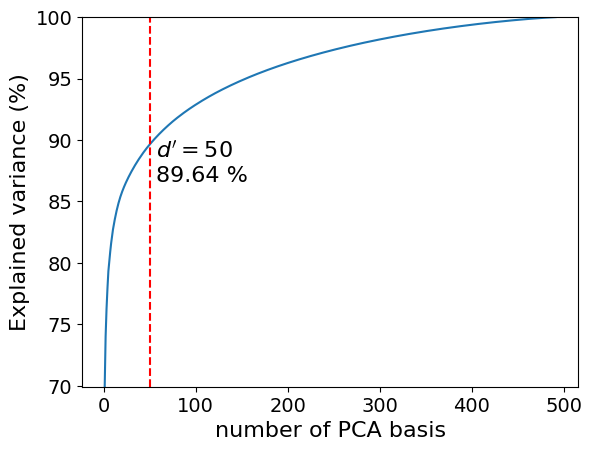

In [4]:
pca = decomposition.PCA(n_components=Xs.shape[0])
pca.fit(Xs)

variances = np.array(pca.explained_variance_)/np.sum(pca.explained_variance_)*100
#print(np.cumsum(variances))
plt.plot(range(1, Xs.shape[0]+1), np.cumsum(variances), '-')
plt.xlabel("number of PCA basis", fontsize=16)
plt.ylabel("Explained variance (%)", fontsize=16)
plt.vlines(x=d_red, ymin=variances[0], ymax=100, color = 'r', linestyles='dashed')
plt.text(x=d_red+7, y= np.cumsum(variances)[d_red-1]-3, s="$d'=%d$\n%.2f %%" % (d_red, np.cumsum(variances)[d_red-1]), fontsize=16)
plt.ylim([variances[0], 100])
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

In [5]:
# perform PCA
pca = decomposition.PCA(n_components=d_red, random_state=0)
pca.fit(Xs)

Xs_red = pca.transform(Xs)
Xs1_red = Xs_red[:Xs1.shape[0],:]
Xs2_red = Xs_red[Xs1.shape[0]:,:]

# reconstruction
Xs1_hat = pca.inverse_transform(Xs1_red)
Xs2_hat = pca.inverse_transform(Xs2_red)

X1_hat = scaler.inverse_transform(Xs1_hat)
X2_hat = scaler.inverse_transform(Xs2_hat)

print("Sinkhorn divergence on entire data: standardized (left), reconstructed (right)")
print("Source: ", sinkhorn(Xs1_hat, Xs1), sinkhorn(X1_hat, X1))     
print("Target: ", sinkhorn(Xs2_hat, Xs2), sinkhorn(X2_hat, X2))

X1_p, X1_n = X1[X1_label==1], X1[X1_label==0]
X2_p, X2_n = X2[X2_label==1], X2[X2_label==0]

Xs1_p, Xs1_n = Xs1[X1_label==1], Xs1[X1_label==0]
Xs2_p, Xs2_n = Xs2[X2_label==1], Xs2[X2_label==0]

X1_p_hat, X1_n_hat = X1_hat[X1_label==1], X1_hat[X1_label==0]
X2_p_hat, X2_n_hat = X2_hat[X2_label==1], X2_hat[X2_label==0]

Xs1_p_hat, Xs1_n_hat = Xs1_hat[X1_label==1], Xs1_hat[X1_label==0]
Xs2_p_hat, Xs2_n_hat = Xs2_hat[X2_label==1], Xs2_hat[X2_label==0]

print("\nSinkhorn divergence on source data: standardized (left), reconstructed (right)")
print("Source positive: ", sinkhorn(Xs1_p_hat, Xs1_p), sinkhorn(X1_p_hat, X1_p))
print("Source negative: ", sinkhorn(Xs1_n_hat, Xs1_n), sinkhorn(X1_n_hat, X1_n))

print("\nSinkhorn divergence on target data: standardized (left), reconstructed (right)")
print("Target positive: ",sinkhorn(Xs2_p_hat, Xs2_p), sinkhorn(X2_p_hat, X2_p))
print("Target negative: ",sinkhorn(Xs2_n_hat, Xs2_n), sinkhorn(X2_n_hat, X2_n))

Sinkhorn divergence on entire data: standardized (left), reconstructed (right)
Source:  3600.0032 5809.499
Target:  2196.9731 3305.643

Sinkhorn divergence on source data: standardized (left), reconstructed (right)
Source positive:  3508.1565 5691.573
Source negative:  3744.041 5994.3247

Sinkhorn divergence on target data: standardized (left), reconstructed (right)
Target positive:  1965.5648 2976.8008
Target negative:  2249.4695 3380.5464


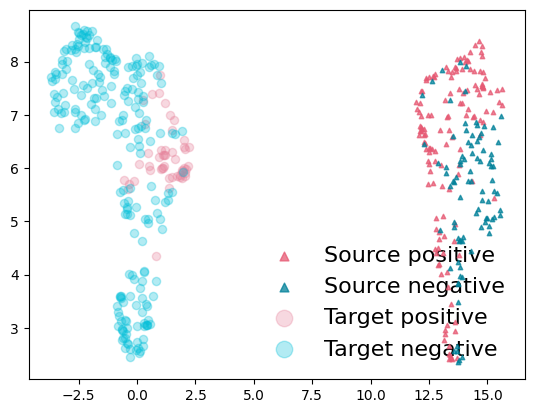

In [6]:
# plot parameters
s1, s2 = 10, 35
alpha1, alpha2 = 0.75, 0.3
color1_p, color1_n = np.array([0.9, 0.35, 0.45]), np.array([0.0, 0.5, 0.6])
color2_p, color2_n = np.array([0.9, 0.5, 0.6]), np.array([0.0, 0.75, 0.85])


reducer = umap.UMAP(random_state=100)
reducer.fit(np.concatenate((Xs1_red, Xs2_red)))
    
Xs1_red_vis = reducer.transform(Xs1_red)
Xs2_red_vis = reducer.transform(Xs2_red)

plt.scatter(Xs1_red_vis[X1_label==1,0], Xs1_red_vis[X1_label==1,1], s=s1, color=color1_p, marker='^',label="Source positive",alpha=alpha1, zorder=10)
plt.scatter(Xs1_red_vis[X1_label==0,0], Xs1_red_vis[X1_label==0,1], s=s1, color=color1_n, marker='^', label="Source negative", alpha=alpha1, zorder=10)
plt.scatter(Xs2_red_vis[X2_label==1,0], Xs2_red_vis[X2_label==1,1], s=s2, color=color2_p, marker='o',label="Target positive", alpha=alpha2, zorder=20)
plt.scatter(Xs2_red_vis[X2_label==0,0], Xs2_red_vis[X2_label==0,1], s=s2, color=color2_n, marker='o', label="Target negative", alpha=alpha2, zorder=20)

plt.legend(fontsize="16", frameon=False, loc='lower right', markerscale=2)

plt.show()

In [7]:
# save basis
pk.dump([pca, scaler], open(folder_name+"pca_norm_"+str(d_red)+".pkl","wb"))

np.savetxt(folder_name+"source_norm_dataset_dim_"+str(d_red)+".csv", Xs1_red, delimiter=",")
np.savetxt(folder_name+"target_norm_dataset_dim_"+str(d_red)+".csv", Xs2_red, delimiter=",")

## Run GPA in the latent space

In [ ]:
!python3 GPA_NN.py --dataset Labeled_disease --exp_no positive
!python3 GPA_NN.py --dataset Labeled_disease --exp_no negative

## Reconstruct GPA result

In [8]:
def calculate_time_steps(dt, iter_nos, physical_time=True):
# calculate real_time / iteration count
    if physical_time == True:
        iter_nos_new = []
        if type(dt) == list: # decaying or varying dt
            for iter_no in iter_nos:
                if iter_no == 0:
                    iter_nos_new.append(0)
                else:
                    iter_nos_new.append(sum(dt[:iter_no]))
        else: # constant dt
            for iter_no in iter_nos:
                iter_nos_new.append(dt*iter_no)
        iter_nos = iter_nos_new
    return iter_nos

In [9]:
# back mapping 
folder_name = main_dir + "/data/gene_expression_example/GPL570/Labeled_disease/"
target_name = "GSE76275"
source_name = "GSE26639"

# read original source and target data
dset1_name = folder_name + source_name + ".csv" # source distribution
dset2_name = folder_name + target_name + ".csv" # target distribution

data1 = pd.read_csv(dset1_name)
X1 = pd.DataFrame.to_numpy(data1).T
(n1, d) = X1.shape
print(n1, d)

data2 = pd.read_csv(dset2_name)
X2 = pd.DataFrame.to_numpy(data2).T
(n2, d) = X2.shape
print(n2, d)


# read labels
dset1_label_name = folder_name + source_name + "_label.csv" # source distribution label
dset2_label_name = folder_name + target_name + "_label.csv" # target distribution label

label1 = pd.read_csv(dset1_label_name, header=None)
X1_label = np.zeros(len(label1))
l1 = np.squeeze(pd.DataFrame.to_numpy(label1))
X1_label[l1 == 'positive'] = 1
X1_label[l1 == 'Positive'] = 1

label2 = pd.read_csv(dset2_label_name, header=None)
X2_label = np.zeros(len(label2))
l2 = np.squeeze(pd.DataFrame.to_numpy(label2))
X2_label[l2 == 'positive'] = 1
X2_label[l2 == 'Positive'] = 1


# read source and target distributions in latent space
red_dset1_name = folder_name+"source_norm_dataset_dim_"+str(d_red)+".csv" # source distribution in latent space
red_dset2_name = folder_name+"target_norm_dataset_dim_"+str(d_red)+".csv" # target distribution in latent space

red_data1 = pd.read_csv(red_dset1_name, header=None)
Xs1_red = pd.DataFrame.to_numpy(red_data1)

red_data2 = pd.read_csv(red_dset2_name, header=None)
Xs2_red = pd.DataFrame.to_numpy(red_data2)


# transported positve/negataive distributions in latent space
folder_name2= "../../assets/Labeled_disease/"
trans_red_dset1_p_name = folder_name2+"KL-Lipschitz_1.0000_dim"+str(d_red)+"_uncond_0049_0138_00_positive.pickle"
trans_red_dset1_n_name = folder_name2+"KL-Lipschitz_1.0000_dim"+str(d_red)+"_uncond_0216_0088_00_negative.pickle"


with open(trans_red_dset1_p_name, "rb") as fr:
    param, result = pk.load(fr)
    Xs1_p_red_trpts = result['trajectories']

with open(trans_red_dset1_n_name, "rb") as fr:
    param, result = pk.load(fr)
    Xs1_n_red_trpts = result['trajectories']

ts = [int(r*param['epochs']) for r in [0.09, 0.12, 0.99999]]
print("transport time step: ", ts)
pts = calculate_time_steps(param['lr_P'], ts)
print("transport physical time step: ", pts)
    
Xs1_p_red_trpts = [Xs1_p_red_trpts[int(t/param['save_iter'])] for t in ts]
Xs1_n_red_trpts = [Xs1_n_red_trpts[int(t/param['save_iter'])] for t in ts]

226 54675
265 54675
transport time step:  [450, 600, 4999]
transport physical time step:  [90.0, 120.0, 999.8000000000001]


In [10]:
def pca_reconstruction(X_red):
    Xs_hat = pca.inverse_transform(X_red) # scaled reconstruction
    X_hat = scaler.inverse_transform(Xs_hat) # scale it back
    
    return X_hat

def sinkhorn_fixed_latent(
    Xs1_red=Xs1_red, 
    X1_label=X1_label, 
    Xs2_red=Xs2_red, 
    X2_label=X2_label
):
    print("sinkhorn divergence in the latent space: positive (left), negative (right)")
    d_red1_red2_p = sinkhorn(Xs1_red[X1_label==1], Xs2_red[X2_label==1])
    d_red1_red2_n = sinkhorn(Xs1_red[X1_label==0], Xs2_red[X2_label==0])
    print(f"(Y_0, X) {d_red1_red2_p}, {d_red1_red2_n}")
    
def sinkhorn_fixed_original(
    X1=X1, 
    X1_hat=X1_hat, 
    X1_label=X1_label, 
    X2=X2, 
    X2_hat=X2_hat, 
    X2_label=X2_label
):
    print("sinkhorn in the original space: positive (left), negative (right)")
    d_1orig_2orig_p = sinkhorn(X1[X1_label==1], X2[X2_label==1])
    d_1orig_2orig_n = sinkhorn(X1[X1_label==0], X2[X2_label==0])
    print(f"(Y_0 original, X original) {d_1orig_2orig_p}, {d_1orig_2orig_n}")   

    d_1orig_1recon_p = sinkhorn(X1[X1_label==1], X1_hat[X1_label==1])
    d_1orig_1recon_n = sinkhorn(X1[X1_label==0], X1_hat[X1_label==0])
    print(f"(Y_0 original, Y_0): {d_1orig_1recon_p}, {d_1orig_1recon_n}")    
    
    d_2orig_2recon_p = sinkhorn(X2[X2_label==1], X2_hat[X2_label==1])
    d_2orig_2recon_n = sinkhorn(X2[X2_label==0], X2_hat[X2_label==0])
    print(f"(X original, X): {d_2orig_2recon_p}, {d_2orig_2recon_n}")
    
    
def sinkhorn_trajectory_latent(
    Xs1_p_red_trpt, Xs1_n_red_trpt, 
    Xs1_red=Xs1_red,
    X1_label=X1_label,
    Xs2_red=Xs2_red,
    X2_label=X2_label, 
):
    print("sinkhorn in the latent space: positive (left), negative (right)")
    d_1_1t_p = sinkhorn(Xs1_red[X1_label==1], Xs1_p_red_trpt)
    d_1_1t_n = sinkhorn(Xs1_red[X1_label==0], Xs1_n_red_trpt)
    print(f"(Y_0, Y_t): {d_1_1t_p}, {d_1_1t_n}")
    
    d_2_2t_p = sinkhorn(Xs2_red[X2_label==1], Xs1_p_red_trpt)
    d_2_2t_n = sinkhorn(Xs2_red[X2_label==0], Xs1_n_red_trpt)
    print(f"(X, Y_t): {d_2_2t_p}, {d_2_2t_n}")
      
    
def sinkhorn_trajectory_original(
    X1_p_trpt_hat, X1_n_trpt_hat, 
    X1=X1,
    X1_label=X1_label,
    X2=X2,
    X2_label=X2_label,
):
    print("sinkhorn in the original space: positive (left), negative (right)")
    d_1orig_1t_p = sinkhorn(X1[X1_label==1], X1_p_trpt_hat)
    d_1orig_1t_n = sinkhorn(X1[X1_label==0], X1_n_trpt_hat)
    print(f"(Y_0 original, Y_T): {d_1orig_1t_p}, {d_1orig_1t_n}")
    
    d_2orig_2t_p = sinkhorn(X2[X2_label==1], X1_p_trpt_hat)
    d_2orig_2t_n = sinkhorn(X2[X2_label==0], X1_n_trpt_hat)
    print(f"(X original, Y_T): {d_2orig_2t_p}, {d_2orig_2t_n}")
    

In [11]:
# Process fixed data
# reconstruction
pca, scaler = pk.load(open(folder_name+"pca_norm_"+str(d_red)+".pkl", 'rb'))
X1_hat = pca_reconstruction(Xs1_red)
X2_hat = pca_reconstruction(Xs2_red)
sinkhorn_fixed_latent()
print()
sinkhorn_fixed_original()


sinkhorn divergence in the latent space: positive (left), negative (right)
(Y_0, X) 84320.390625, 83507.265625

sinkhorn in the original space: positive (left), negative (right)
(Y_0 original, X original) 238839.59375, 238455.65625
(Y_0 original, Y_0): 5691.5732421875, 5994.32470703125
(X original, X): 2976.80078125, 3380.54638671875


In [12]:
i=0
for traj_p, traj_n in zip(Xs1_p_red_trpts, Xs1_n_red_trpts):
    print(f"time: {pts[i]}")
    
    Xs1_p_red_trpt, Xs1_n_red_trpt = traj_p, traj_n
    sinkhorn_trajectory_latent(Xs1_p_red_trpt, Xs1_n_red_trpt)
    
    ## reconstruction ##
    X1_p_trpt_hat = pca_reconstruction(Xs1_p_red_trpt)
    X1_n_trpt_hat = pca_reconstruction(Xs1_n_red_trpt)

    sinkhorn_trajectory_original(X1_p_trpt_hat, X1_n_trpt_hat)
    i += 1
    print()

time: 90.0
sinkhorn in the latent space: positive (left), negative (right)
(Y_0, Y_t): 18142.3203125, 14203.041015625
(X, Y_t): 32875.58203125, 35291.45703125
sinkhorn in the original space: positive (left), negative (right)
(Y_0 original, Y_T): 55069.48046875, 46444.1171875
(X original, Y_T): 85427.7265625, 93077.796875

time: 120.0
sinkhorn in the latent space: positive (left), negative (right)
(Y_0, Y_t): 63025.39453125, 43234.52734375
(X, Y_t): 9697.916015625, 13104.8828125
sinkhorn in the original space: positive (left), negative (right)
(Y_0 original, Y_T): 182436.453125, 130413.328125
(X original, Y_T): 19851.765625, 30293.580078125

time: 999.8000000000001
sinkhorn in the latent space: positive (left), negative (right)
(Y_0, Y_t): 83922.8203125, 82919.6875
(X, Y_t): 399.39569091796875, 2067.5478515625
sinkhorn in the original space: positive (left), negative (right)
(Y_0 original, Y_T): 235857.34375, 234368.40625
(X original, Y_T): 3517.19482421875, 6224.73974609375



In [13]:
print(3517.1/238830)
print(6224.7/238450)

0.014726374408575136
0.026104843782763683


In [14]:
# compare with simple 
scaler_1p = StandardScaler()# Fit on training set only.
scaler_1p.fit(X1[X1_label==1])
Xs_1p = scaler_1p.transform(X1[X1_label==1])

scaler_2p = StandardScaler()# Fit on training set only.
scaler_2p.fit(X2[X2_label==1])
#Xs_2p = scaler_2p.transform(X2[X2_label==1])

Xs_1p_to_X2p = scaler_2p.inverse_transform(Xs_1p)
print("Simple positive: ", sinkhorn(Xs_1p_to_X2p, X2[X2_label==1]))


scaler_1n = StandardScaler()# Fit on training set only.
scaler_1n.fit(X1[X1_label==0])
Xs_1n = scaler_1n.transform(X1[X1_label==0])

scaler_2n = StandardScaler()# Fit on training set only.
scaler_2n.fit(X2[X2_label==0])
#Xs_2n = scaler_2n.transform(X2[X2_label==0])

Xs_1n_to_X2n = scaler_2n.inverse_transform(Xs_1n)
print("Simple negative: ", sinkhorn(Xs_1n_to_X2n, X2[X2_label==0]))

Simple positive:  9440.277
Simple negative:  11617.953


In [15]:
print(9440.2/238830)
print(11617/238450)

0.03952686010970147
0.048718808974627804


In [16]:
reducer1, reducer2 = pk.load(open(folder_name+"umap_norm_"+str(d_red)+".pkl", 'rb'))

In [17]:
# Plot fixed part
# 1. Source vs. target : latent space
# dimensionality reduction for visualization 
try:
    X1_red_vis = reducer1.transform(Xs1_red)
    X2_red_vis = reducer1.transform(Xs2_red)
except:
    reducer1 = umap.UMAP()
    reducer1.fit(np.concatenate([Xs1_red, Xs2_red]))
    
    X1_red_vis = reducer1.transform(Xs1_red)
    X2_red_vis = reducer1.transform(Xs2_red)

In [18]:
# 2. Source vs. target : original space
# dimensionality reduction for visualization 
try:
    X1_vis = reducer2.transform(X1)
    X2_vis = reducer2.transform(X2)
except:
    reducer2 = umap.UMAP()
    reducer2.fit(np.concatenate((X1, X2)))
    
    X1_vis = reducer2.transform(X1)
    X2_vis = reducer2.transform(X2)

In [19]:
# plot parameters
s1, s2 = 10, 35
alpha1, alpha2 = 0.75, 0.3
color1_p, color1_n = np.array([0.9, 0.35, 0.45]), np.array([0.0, 0.5, 0.6])
color2_p, color2_n = np.array([0.9, 0.5, 0.6]), np.array([0.0, 0.75, 0.85])


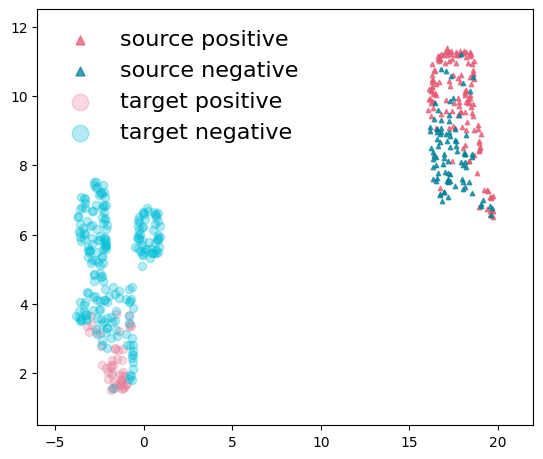

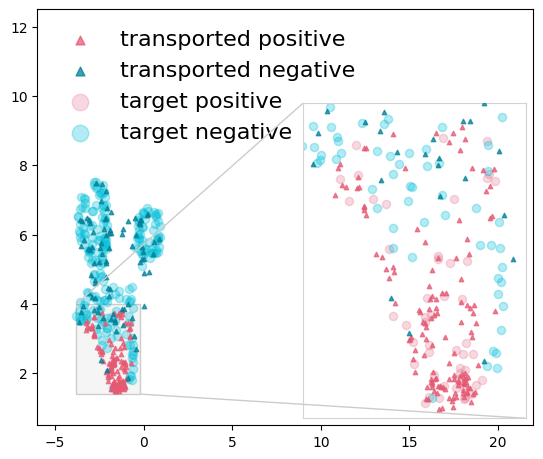

In [20]:
# 3. Source vs target : original space
X1_vis = reducer2.transform(X1)
X2_vis = reducer2.transform(X2)

main_xlims, main_ylims = [-6, 22], [0.5, 12.5]

fig1, ax1 = plt.subplots(figsize=(6.4,5.4))
ax1.scatter(X1_vis[X1_label==1, 0], X1_vis[X1_label==1, 1], s=s1, color=color1_p, marker='^', label='source positive',alpha=alpha1, zorder=10)
ax1.scatter(X1_vis[X1_label==0, 0], X1_vis[X1_label==0, 1], s=s1, color=color1_n, marker='^', label='source negative', alpha=alpha1, zorder=20)

ax1.scatter(X2_vis[X2_label==1, 0], X2_vis[X2_label==1, 1], s=s2,color=color2_p, marker='o', label='target positive' , alpha=alpha2, zorder=1)
ax1.scatter(X2_vis[X2_label==0, 0], X2_vis[X2_label==0, 1], s=s2, color=color2_n, marker='o', label='target negative' , alpha=alpha2, zorder=2)

ax1.legend(fontsize="16", frameon=False, loc='upper left', markerscale=2)
#plt.tight_layout()
ax1.set_xlim(main_xlims)
ax1.set_ylim(main_ylims)
plt.show()

# 4. Transported vs target : original space
X1_p_trpt_vis = reducer2.transform(X1_p_trpt_hat)
X1_n_trpt_vis = reducer2.transform(X1_n_trpt_hat)

fig, ax = plt.subplots(figsize=(6.4,5.4))
# zoomed part
axins = zoomed_inset_axes(ax, 3.5, loc='lower right', )#axes_kwargs={"facecolor": "lightgray"})

ax.scatter(X1_p_trpt_vis[:, 0], X1_p_trpt_vis[:, 1], s=s1, color=color1_p, marker='^', label='transported positive',alpha=alpha1, zorder=10)
ax.scatter(X1_n_trpt_vis[:, 0], X1_n_trpt_vis[:, 1], s=s1, color=color1_n, marker='^', label='transported negative', alpha=alpha1, zorder=20)

ax.scatter(X2_vis[X2_label==1, 0], X2_vis[X2_label==1, 1], s=s2,color=color2_p, marker='o', label='target positive' , alpha=alpha2, zorder=1)
ax.scatter(X2_vis[X2_label==0, 0], X2_vis[X2_label==0, 1], s=s2, color=color2_n, marker='o', label='target negative' , alpha=alpha2, zorder=2)

axins.scatter(X1_p_trpt_vis[:, 0], X1_p_trpt_vis[:, 1], s=s1, color=color1_p, marker='^', label='transported positive',alpha=alpha1, zorder=10)
axins.scatter(X1_n_trpt_vis[:, 0], X1_n_trpt_vis[:, 1], s=s1, color=color1_n, marker='^', label='transported negative', alpha=alpha1, zorder=20)

axins.scatter(X2_vis[X2_label==1, 0], X2_vis[X2_label==1, 1], s=s2,color=color2_p, marker='o', label='target positive' , alpha=alpha2, zorder=1)
axins.scatter(X2_vis[X2_label==0, 0], X2_vis[X2_label==0, 1], s=s2, color=color2_n, marker='o', label='target negative' , alpha=alpha2, zorder=2)

xlims = [-3.8, -0.2]
ylims = [1.4, 4.0]
axins.set_xlim(xlims)
axins.set_ylim(ylims)
axins.set_xticks([])
axins.set_yticks([])
axins.spines['left'].set_color('lightgray')      
axins.spines['top'].set_color('lightgray') 
axins.spines['right'].set_color('lightgray')      
axins.spines['bottom'].set_color('lightgray') 

ax.set_xlim(main_xlims)
ax.set_ylim(main_ylims)

mark_inset(ax, axins, loc1=2, loc2=4, fc='whitesmoke', ec='0.8')
ax.legend(fontsize="16", frameon=False, loc='upper left', markerscale=2)
#plt.tight_layout()
plt.draw()
plt.show()

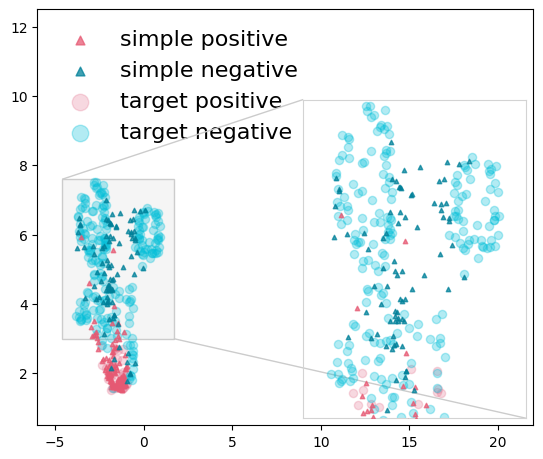

In [21]:
# plot simple estimator
Xs_1p_to_X2p_vis = reducer2.transform(Xs_1p_to_X2p)
Xs_1n_to_X2n_vis = reducer2.transform(Xs_1n_to_X2n)

fig2, ax2 = plt.subplots(figsize=(6.4,5.4))

ax2.scatter(Xs_1p_to_X2p_vis[:, 0], Xs_1p_to_X2p_vis[:, 1], s=s1, color=color1_p, marker='^', label='simple positive',alpha=alpha1, zorder=10)
ax2.scatter(Xs_1n_to_X2n_vis[:, 0], Xs_1n_to_X2n_vis[:, 1], s=s1, color=color1_n, marker='^', label='simple negative', alpha=alpha1, zorder=20)

ax2.scatter(X2_vis[X2_label==1, 0], X2_vis[X2_label==1, 1], s=s2,color=color2_p, marker='o', label='target positive' , alpha=alpha2, zorder=1)
ax2.scatter(X2_vis[X2_label==0, 0], X2_vis[X2_label==0, 1], s=s2, color=color2_n, marker='o', label='target negative' , alpha=alpha2, zorder=2)


# zoomed part
axins2 = zoomed_inset_axes(ax2, 2.0, loc='lower right')#axes_kwargs={"facecolor": "lightgray"})

axins2.scatter(Xs_1p_to_X2p_vis[:, 0], Xs_1p_to_X2p_vis[:, 1], s=s1, color=color1_p, marker='^', label='positive',alpha=alpha1, zorder=10)
axins2.scatter(Xs_1n_to_X2n_vis[:, 0], Xs_1n_to_X2n_vis[:, 1], s=s1, color=color1_n, marker='^', label='negative', alpha=alpha1, zorder=20)

axins2.scatter(X2_vis[X2_label==1, 0], X2_vis[X2_label==1, 1], s=s2,color=color2_p, marker='o', label='target positive' , alpha=alpha2, zorder=1)
axins2.scatter(X2_vis[X2_label==0, 0], X2_vis[X2_label==0, 1], s=s2, color=color2_n, marker='o', label='target negative' , alpha=alpha2, zorder=2)

#xlims = [-3, 0.2]
#ylims = [2.8, 6.5]
xlims2 = [-4.6,1.7]
ylims2 = [3.0,7.6]
#xlims2 = xlims
#ylims2 = ylims
axins2.set_xlim(xlims2)
axins2.set_ylim(ylims2)
axins2.set_xticks([])
axins2.set_yticks([])
axins2.spines['left'].set_color('lightgray')      
axins2.spines['top'].set_color('lightgray') 
axins2.spines['right'].set_color('lightgray')      
axins2.spines['bottom'].set_color('lightgray') 

mark_inset(ax2, axins2, loc1=2, loc2=4, fc='whitesmoke', ec='0.8')


main_xlims2, main_ylims2 = main_xlims, main_ylims
ax2.set_xlim(main_xlims2)
ax2.set_ylim(main_ylims2)

ax2.legend(fontsize="16", frameon=False, loc='upper left', markerscale=2)
#plt.tight_layout()
plt.draw()
plt.show()

In [ ]:
# save UMAP axes
pk.dump([reducer1, reducer2], open(folder_name+"umap_norm_"+str(d_red)+".pkl","wb"))